# Discrete Elastic Shells: Simple Example with Four Nodes
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

# Load Libraries

In [1]:
%pip install pygmsh
import pygmsh
import meshio
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

# Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [2]:
def signedAngle(u = None,v = None,n = None):
    # This function calculates the signed angle between two vectors, "u" and "v",
    # using an optional axis vector "n" to determine the direction of the angle.
    #
    # Parameters:
    #   u: numpy array-like, shape (3,), the first vector.
    #   v: numpy array-like, shape (3,), the second vector.
    #   n: numpy array-like, shape (3,), the axis vector that defines the plane
    #      in which the angle is measured. It determines the sign of the angle.
    #
    # Returns:
    #   angle: float, the signed angle (in radians) from vector "u" to vector "v".
    #          The angle is positive if the rotation from "u" to "v" follows
    #          the right-hand rule with respect to the axis "n", and negative otherwise.
    #
    # The function works by:
    # 1. Computing the cross product "w" of "u" and "v" to find the vector orthogonal
    #    to both "u" and "v".
    # 2. Calculating the angle between "u" and "v" using the arctan2 function, which
    #    returns the angle based on the norm of "w" (magnitude of the cross product)
    #    and the dot product of "u" and "v".
    # 3. Using the dot product of "n" and "w" to determine the sign of the angle.
    #    If this dot product is negative, the angle is adjusted to be negative.
    #
    # Example:
    #   signedAngle(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]))
    #   This would return a positive angle (π/2 radians), as the rotation
    #   from the x-axis to the y-axis is counterclockwise when viewed along the z-axis.
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle

    return angle

In [3]:
def mmt(matrix):
    return matrix + matrix.T

# Hinge angle, its gradient, and Hessian

In [4]:
#          x2
#          /\
#         /  \
#      e1/    \e3
#       /  t0  \
#      /        \
#     /    e0    \
#   x0------------x1
#     \          /
#      \   t1   /
#       \      /
#      e2\    /e4
#         \  /
#          \/
#          x3
#
#  Edge orientation: e0,e1,e2 point away from x0
#                       e3,e4 point away from x1

In [5]:
def getTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0

    n0 = np.cross(m_e0, m_e1)
    n1 = np.cross(m_e2, m_e0)

    # Calculate the signed angle using the provided function
    theta = signedAngle(n0, n1, m_e0)

    return theta

In [6]:
# In the original code, there are probaly TWO sign errors in the expressions for m_h3 and m_h4.
# [Original code: % https://github.com/shift09/plates-shells/blob/master/src/bending.cpp]
# I indicated those two corrections by writing the word "CORRECTION" next
# to them.

def gradTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 = m_nn1 / np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 = m_nn2 / np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3  # CORRECTION
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4  # CORRECTION
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Initialize the gradient
    gradTheta = np.zeros(12)

    gradTheta[0:3] = m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4
    gradTheta[3:6] = m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2
    gradTheta[6:9] = -m_nn1 / m_h01
    gradTheta[9:12] = -m_nn2 / m_h02

    return gradTheta

In [7]:
def hessTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 /= np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 /= np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Gradient of Theta (as an intermediate step)
    grad_theta = np.zeros((12, 1))
    grad_theta[0:3] = (m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4).reshape(-1, 1)
    grad_theta[3:6] = (m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2).reshape(-1, 1)
    grad_theta[6:9] = (-m_nn1 / m_h01).reshape(-1, 1)
    grad_theta[9:12] = (-m_nn2 / m_h02).reshape(-1, 1)

    # Intermediate matrices for Hessian
    m_m1 = np.cross(m_nn1, m_e1) / np.linalg.norm(m_e1)
    m_m2 = -np.cross(m_nn2, m_e2) / np.linalg.norm(m_e2)
    m_m3 = -np.cross(m_nn1, m_e3) / np.linalg.norm(m_e3)
    m_m4 = np.cross(m_nn2, m_e4) / np.linalg.norm(m_e4)
    m_m01 = -np.cross(m_nn1, m_e0) / np.linalg.norm(m_e0)
    m_m02 = np.cross(m_nn2, m_e0) / np.linalg.norm(m_e0)

    # Hessian matrix components
    M331 = m_cosA3 / (m_h3 ** 2) * np.outer(m_m3, m_nn1)
    M311 = m_cosA3 / (m_h3 * m_h1) * np.outer(m_m1, m_nn1)
    M131 = m_cosA1 / (m_h1 * m_h3) * np.outer(m_m3, m_nn1)
    M3011 = m_cosA3 / (m_h3 * m_h01) * np.outer(m_m01, m_nn1)
    M111 = m_cosA1 / (m_h1 ** 2) * np.outer(m_m1, m_nn1)
    M1011 = m_cosA1 / (m_h1 * m_h01) * np.outer(m_m01, m_nn1)

    M442 = m_cosA4 / (m_h4 ** 2) * np.outer(m_m4, m_nn2)
    M422 = m_cosA4 / (m_h4 * m_h2) * np.outer(m_m2, m_nn2)
    M242 = m_cosA2 / (m_h2 * m_h4) * np.outer(m_m4, m_nn2)
    M4022 = m_cosA4 / (m_h4 * m_h02) * np.outer(m_m02, m_nn2)
    M222 = m_cosA2 / (m_h2 ** 2) * np.outer(m_m2, m_nn2)
    M2022 = m_cosA2 / (m_h2 * m_h02) * np.outer(m_m02, m_nn2)

    B1 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn1, m_m01)
    B2 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn2, m_m02)

    N13 = 1 / (m_h01 * m_h3) * np.outer(m_nn1, m_m3)
    N24 = 1 / (m_h02 * m_h4) * np.outer(m_nn2, m_m4)
    N11 = 1 / (m_h01 * m_h1) * np.outer(m_nn1, m_m1)
    N22 = 1 / (m_h02 * m_h2) * np.outer(m_nn2, m_m2)
    N101 = 1 / (m_h01 ** 2) * np.outer(m_nn1, m_m01)
    N202 = 1 / (m_h02 ** 2) * np.outer(m_nn2, m_m02)

    # Initialize Hessian of Theta
    hess_theta = np.zeros((12, 12))

    hess_theta[0:3, 0:3] = mmt(M331) - B1 + mmt(M442) - B2
    hess_theta[0:3, 3:6] = M311 + M131.T + B1 + M422 + M242.T + B2
    hess_theta[0:3, 6:9] = M3011 - N13
    hess_theta[0:3, 9:12] = M4022 - N24
    hess_theta[3:6, 3:6] = mmt(M111) - B1 + mmt(M222) - B2
    hess_theta[3:6, 6:9] = M1011 - N11
    hess_theta[3:6, 9:12] = M2022 - N22
    hess_theta[6:9, 6:9] = -mmt(N101)
    hess_theta[9:12, 9:12] = -mmt(N202)

    # Make the Hessian symmetric
    hess_theta[3:6, 0:3] = hess_theta[0:3, 3:6].T
    hess_theta[6:9, 0:3] = hess_theta[0:3, 6:9].T
    hess_theta[9:12, 0:3] = hess_theta[0:3, 9:12].T
    hess_theta[6:9, 3:6] = hess_theta[3:6, 6:9].T
    hess_theta[9:12, 3:6] = hess_theta[3:6, 9:12].T

    return hess_theta


# Stretching energy for a shell, it's gradient, and Hessian

In [8]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

# Bending energy for a shell, it's gradient, and Hessian

In [9]:
def getEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the bending energy for a shell.

    Returns:
    E (scalar): Bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    E = 0.5 * kb * (theta - theta_bar) ** 2

    return E

In [10]:
def gradEb_hessEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the gradient and Hessian of the bending energy for a shell.

    Parameters:
    x0 (array): Can either be a 3-element array (single point) or a 12-element array.
    x1, x2, x3 (arrays): Optional, 3-element arrays specifying points.
    theta_bar (float): Reference angle.
    kb (float): Bending stiffness.

    Returns:
    dF (array): Gradient of the bending energy.
    dJ (array): Hessian of the bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = dE/dx = 2 * (theta-thetaBar) * gradTheta
    dF = 0.5 * kb * (2 * (theta - theta_bar) * grad)

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = 0.5 * kb * (2 (theta-thetaBar) d theta/dx)
    # J = dF/dx = 0.5 * kb * [ 2 (d theta / dx) transpose(d theta/dx) +
    #       2 (theta-thetaBar) (d^2 theta/ dx^2 ) ]
    hess = hessTheta(x0, x1, x2, x3)  # Replace with your hessTheta function in Python
    dJ = 0.5 * kb * (2 * np.outer(grad, grad) + 2 * (theta - theta_bar) * hess)

    return dF, dJ

# Plot the shell

In [11]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [12]:
def plotShell(x0, ctime):

  x1 = x0[3:6]
  x2 = x0[6:9]
  x3 = x0[9:12]
  x0 = x0[0:3]

  fig = plt.figure(1)
  clear_output()
  plt.clf()  # Clear the figure
  ax = fig.add_subplot(111, projection='3d')

  # Plot nodes
  X = np.array([x0[0], x1[0], x2[0], x0[0], x3[0], x1[0]])
  Y = np.array([x0[1], x1[1], x2[1], x0[1], x3[1], x1[1]])
  Z = np.array([x0[2], x1[2], x2[2], x0[2], x3[2], x1[2]])
  ax.plot3D(X, Y, Z, 'ko-')

  # Plot the first node with a red triangle
  ax.plot3D([X[0]], [Y[0]], [Z[0]], 'r^')

  # Set the title with current time
  ax.set_title(f't={ctime:.2f}')

  # Set axes labels
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Set equal scaling and a 3D view
  set_axes_equal(ax)
  plt.draw()  # Force a redraw of the figure

  plt.show()

# Objective function

In [13]:
def objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
           ks, refLen, edges,
           kb, thetaBar, hinges,
           Fg, visc):

  qNew = qOld.copy()
  ndof = len(qOld) # Number of DOFs

  iter = 0 # number of iteration
  error = 10 * tol
  # Newton Raphson
  while error > tol:

    # Bending force and jacobian
    Fb = np.zeros( ndof )
    Jb = np.zeros( (ndof,ndof) )
    # Loop over every "bending spring" or "hinge"
    for kHinge in range(hinges.shape[0]):
      node0 = hinges[kHinge, 0]
      node1 = hinges[kHinge, 1]
      node2 = hinges[kHinge, 2]
      node3 = hinges[kHinge, 3]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      x2 = qNew[ 3*node2: 3*node2 + 3]
      x3 = qNew[ 3*node3: 3*node3 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2,
             3*node2, 3*node2 + 1, 3*node2 + 2,
             3*node3, 3*node3 + 1, 3*node3 + 2]
      dF, dJ = gradEb_hessEb_Shell(x0, x1, x2, x3, 0, kb)
      Fb[ind] -= dF
      Jb[np.ix_(ind,ind)] -= dJ

    # Stretching force and jacobian
    Fs = np.zeros( ndof )
    Js = np.zeros( (ndof,ndof) )
    for kEdge in range(edges.shape[0]):
      node0 = edges[kEdge, 0]
      node1 = edges[kEdge, 1]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2]
      dF, dJ = gradEs_hessEs(x0, x1, refLen[kEdge], ks[kEdge])
      Fs[ind] -= dF
      Js[np.ix_(ind,ind)] -= dJ

    # Viscous force
    Fv = - visc * (qNew - qOld) / dt
    Jv = - visc / dt * np.eye(ndof)

    Forces = Fb + Fs + Fg + Fv # Sum of forces
    JForces = Jb + Js + Jv # Sum of Jacobians

    # Set up my equations of motion and calculating its residual (=0)
    f = massVector / dt * ( (qNew - qOld)/dt - uOld) - Forces # Residual of EOM
    J = massMatrix / dt ** 2 - JForces

    # Extract the free part of the f and J arrays
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]
    # Correction
    dq_free = np.linalg.solve(J_free, f_free)

    # Update my guess for position
    qNew[freeIndex] -= dq_free

    # Calculate error
    error = np.sum( np.abs(f_free))

    iter += 1

    print('Iter = ', iter, ' error=', error)

  uNew = (qNew - qOld) / dt
  return qNew, uNew

# Main Discrete Shells

In [30]:
def mesh_plate(l, w, max_mesh_size):
    with pygmsh.geo.Geometry() as geom:
        # Define the rectangle geometry
        geom.add_rectangle(0, l, 0, w, 0, mesh_size=max_mesh_size)

        # Generate the mesh
        mesh = geom.generate_mesh()

    # Extract the node coordinates and elements
    nodes = mesh.points[:, :2]
    elements = mesh.cells_dict["triangle"]
    print(nodes)
    print(elements)
    return nodes, elements

def plot_mesh(nodes, elements):
    plt.figure(figsize=(8, 6))

    # Plot each triangle element
    for element in elements:
        triangle = nodes[element, :]
        # Draw lines for each edge of the triangle
        for i in range(3):
            x_values = triangle[[i, (i + 1) % 3], 0]  # Connect vertices i and (i+1)%3
            y_values = triangle[[i, (i + 1) % 3], 1]
            plt.plot(x_values, y_values, color='black')  # Draw triangle edge

    # Plot nodes
    plt.scatter(nodes[:, 0], nodes[:, 1], color='red', label='Nodes', zorder=5)

    # Set plot properties
    plt.title('Mesh Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.show()

**DOFs and Nodes**

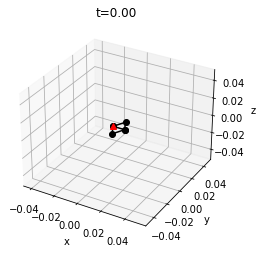

In [31]:
x0 = np.array([0, 0, 0])
x1 = np.array([0.01, 0, 0])
x2 = np.array([0.005, 0.01, 0])
x3 = np.array([0.005, -0.01, 0])

qOld = np.concatenate((x0, x1, x2, x3))
plotShell(qOld, 0)

nv = 4
ndof = 3 * nv
visc = 0 # May need for convergence

**Springs: Create edges (stretching) and hinges (bending)**

In [15]:
edges = np.array( [ (0,1), (0,2), (0,3), (1,2), (1,3)  ] )
hinges = np.array( [ (0,1, 2, 3)  ] )

[[0.      0.     ]
 [0.1     0.     ]
 [0.1     0.01   ]
 [0.      0.01   ]
 [0.0125  0.     ]
 [0.025   0.     ]
 [0.0375  0.     ]
 [0.05    0.     ]
 [0.0625  0.     ]
 [0.075   0.     ]
 [0.0875  0.     ]
 [0.0875  0.01   ]
 [0.075   0.01   ]
 [0.0625  0.01   ]
 [0.05    0.01   ]
 [0.0375  0.01   ]
 [0.025   0.01   ]
 [0.0125  0.01   ]
 [0.00625 0.005  ]
 [0.09375 0.005  ]
 [0.01875 0.005  ]
 [0.08125 0.005  ]
 [0.03125 0.005  ]
 [0.06875 0.005  ]
 [0.04375 0.005  ]
 [0.05625 0.005  ]]
[[15 16 22]
 [ 9 10 21]
 [10  1 19]
 [17  3 18]
 [13 14 25]
 [16 17 20]
 [ 6  7 24]
 [12 13 23]
 [ 8  9 23]
 [ 4  5 20]
 [14 15 24]
 [ 7  8 25]
 [ 0  4 18]
 [ 2 11 19]
 [11 12 21]
 [ 5  6 22]
 [14  7 25]
 [ 7 14 24]
 [13  8 23]
 [16  5 22]
 [10 11 21]
 [ 5 16 20]
 [ 3  0 18]
 [ 1  2 19]
 [ 4 17 18]
 [11 10 19]
 [17  4 20]
 [12  9 21]
 [ 6 15 22]
 [ 9 12 23]
 [15  6 24]
 [ 8 13 25]]


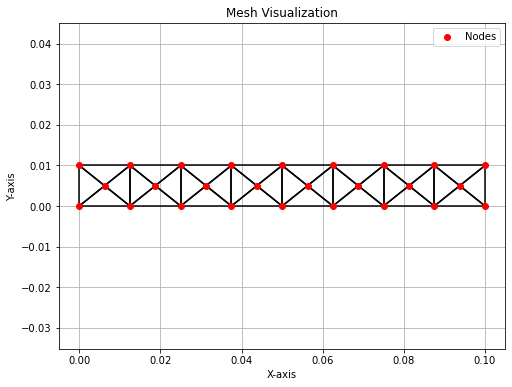

In [32]:
# Define your parameters
l = 0.1  # Length of the rectangle
w = 0.01  # Width of the rectangle
max_mesh_size = 0.0125

# Generate mesh
nodes, elements = mesh_plate(l, w, max_mesh_size)
nv = nodes.shape[0]
ndof = 3 * nv
visc = 0 # May need for convergence

# Plot the mesh
plot_mesh(nodes, elements)

**Elastic Stiffness**

In [ ]:
Y = 1e7	# Young's Modulus
h =  0.002 # Thickness of the rectangle
A = w * h	# Cross-sectional Area
I  = (w * h**3) / 12  # Area Moment of Inertia

# Stiffness variables
kb = 2.0 / np.sqrt(3.0) * Y * h**3.0 / 12 # Bending stiffness (Newton-meter)
refLen = np.zeros(edges.shape[0]) # reference length, denoted as l_k
ks = np.zeros_like(refLen) # Stretching stiffness
for kEdge in range(edges.shape[0]):
  node0 = edges[kEdge, 0]
  node1 = edges[kEdge, 1]
  x0 = qOld[ 3*node0: 3*node0 + 3]
  x1 = qOld[ 3*node1: 3*node1 + 3]
  refLen[kEdge] = np.linalg.norm(x1 - x0)
  ks[kEdge] = np.sqrt(3.0) / 2.0 * Y * h * (refLen[kEdge]) ** 2

**Time parameters**

In [19]:
totalTime = 5 # seconds
dt = 0.001 # time step sie

tol = kb / (0.01) * 1e-3 # Approximate tolerance

**Mass Vector and Matrix**

In [ ]:
rho = 1000	# Density
g = -9.81	# Gravitational acceleration
q = rho*A*g # Distributed load due to gravity

totalM = 0.01 # total mass in kg
dm = totalM / nv # mass per nodes -- approximation
massVector = np.zeros(ndof)
for c in range(nv): # Loop over every node
  ind = [3*c, 3*c+1, 3*c+2] # location of the c-th node in the DOF vector
  massVector[ind] = dm

massMatrix = np.diag(massVector)

**External force**

In [21]:
g = np.array([0, 0, -9.8])
Fg = np.zeros(ndof)
for c in range(nv):
  ind = [3*c, 3*c+1, 3*c+2]
  Fg[ind] = massVector[ind] * g

**Natural curvature**

In [28]:
print(nodes)
qOld = nodes
thetaBar = getTheta(qOld)

[[0.      0.     ]
 [0.1     0.     ]
 [0.1     0.01   ]
 [0.      0.01   ]
 [0.0125  0.     ]
 [0.025   0.     ]
 [0.0375  0.     ]
 [0.05    0.     ]
 [0.0625  0.     ]
 [0.075   0.     ]
 [0.0875  0.     ]
 [0.0875  0.01   ]
 [0.075   0.01   ]
 [0.0625  0.01   ]
 [0.05    0.01   ]
 [0.0375  0.01   ]
 [0.025   0.01   ]
 [0.0125  0.01   ]
 [0.00625 0.005  ]
 [0.09375 0.005  ]
 [0.01875 0.005  ]
 [0.08125 0.005  ]
 [0.03125 0.005  ]
 [0.06875 0.005  ]
 [0.04375 0.005  ]
 [0.05625 0.005  ]]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

**Boundary conditions and Initial Conditions**

In [23]:
# qOld is already computed
uOld = np.zeros(ndof) # Initialize velocity

fixedIndex = np.arange(0,9)
freeIndex = np.arange(9, ndof) # Only x_3 is free

**Time stepping loop**

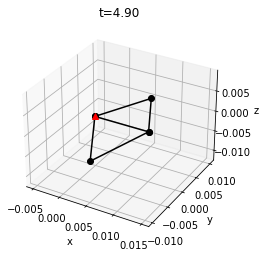

Current time =4.901000
Iter =  1  error= 4.912021125222377e-06
Current time =4.902000
Iter =  1  error= 6.3375357123481024e-06
Current time =4.903000
Iter =  1  error= 7.731787225053778e-06
Current time =4.904000
Iter =  1  error= 9.089286672894943e-06
Current time =4.905000
Iter =  1  error= 1.0404715184222924e-05
Current time =4.906000
Iter =  1  error= 1.1672944745954976e-05
Current time =4.907000
Iter =  1  error= 1.2889058089987117e-05
Current time =4.908000
Iter =  1  error= 1.4048367650495129e-05
Current time =4.909000
Iter =  1  error= 1.5146433504116888e-05
Current time =4.910000
Iter =  1  error= 1.61790802655562e-05
Current time =4.911000
Iter =  1  error= 1.7142412832393643e-05
Current time =4.912000
Iter =  1  error= 1.8032830939107743e-05
Current time =4.913000
Iter =  1  error= 1.8847042480921346e-05
Current time =4.914000
Iter =  1  error= 1.958207550855403e-05
Current time =4.915000
Iter =  1  error= 2.023528892348362e-05
Current time =4.916000
Iter =  1  error= 2.0804

In [24]:
Nsteps = round(totalTime / dt) # Number of time steps
ctime = 0 # Current time
endZ = np.zeros(Nsteps) # z-coordinate of the last node

for timeStep in range(Nsteps):
  print('Current time =%f' % ctime)

  qNew, uNew = objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix, ks, refLen, edges, kb, thetaBar, hinges, Fg, visc)
  ctime += dt

  # Update my old positions and velocities
  qOld = qNew.copy()
  uOld = uNew.copy()

  # Store endZ
  endZ[timeStep] = qNew[-1]

  # Plot the shell
  if timeStep % 100 == 0:
    plotShell(qOld, ctime)

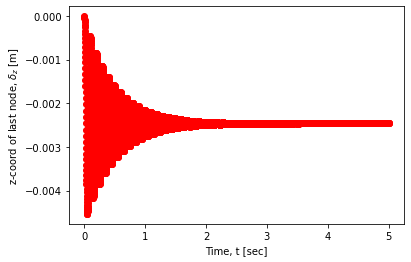

In [25]:
# Visualize
plt.figure(2)
time_array = np.arange(1, Nsteps+1) * dt
plt.plot(time_array, endZ, 'ro-')
plt.box(True)
plt.xlabel('Time, t [sec]')
plt.ylabel('z-coord of last node, $\\delta_z$ [m]')
plt.show()